In [2]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
from hess.data import data_loader
import numpy as np
import sklearn.datasets as datasets

In [50]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [53]:
X, Y = twospirals(500, noise=1.5)

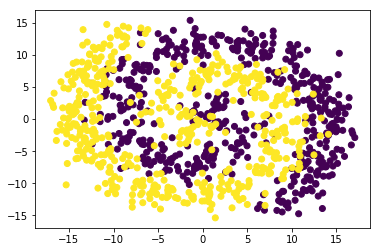

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [55]:
train_x = torch.FloatTensor(X)

In [56]:
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [57]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(4)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [58]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [59]:
print(sum(p.numel() for p in optimus.net.parameters()))

1761


In [60]:
if use_cuda:
    optimus = optimus.cuda()

In [61]:
out = optimus(train_x)

In [62]:
print(out.shape)

torch.Size([1000, 1])


In [63]:
optimus.train_net(print_loss=True, lr=0.01, iters=2500,
                 loss_func=torch.nn.BCELoss())

tensor(0.7061, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6581, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6263, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6261, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6190, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6081, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6089, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6120, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6075, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5990, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5784, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5720, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5664, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5529, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5434, grad_fn=<BinaryCrossEntropyBack

tensor(0.2397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2829, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2723, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2519, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2654, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2617, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2648, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2384, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2547, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2434, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2450, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2460, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2383, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2411, grad_fn=<BinaryCrossEntropyBack

tensor(0.2159, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2158, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2157, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2156, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2155, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2154, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2153, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2151, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2150, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2149, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2148, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2147, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2146, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2146, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2145, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2145, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2146, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2150, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2162, grad_fn=<BinaryCrossEntropyBack

tensor(0.2272, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2337, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2207, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2187, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2226, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2151, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2194, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2155, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2151, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2137, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2138, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2112, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2145, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2115, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2094, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2104, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2111, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2090, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2090, grad_fn=<BinaryCrossEntropyBack

tensor(0.1927, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1926, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1924, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1923, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1921, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1920, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1919, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1917, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1916, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1914, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1913, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1912, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1910, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1909, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1907, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1906, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1905, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1903, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1902, grad_fn=<BinaryCrossEntropyBack

tensor(0.1960, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1959, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1957, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1955, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1954, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1952, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1951, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1949, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1947, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1946, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1944, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1943, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1941, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1940, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1938, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1937, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1935, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1934, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1932, grad_fn=<BinaryCrossEntropyBack

tensor(0.1748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1749, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1761, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1775, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1815, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1817, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1843, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1798, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1766, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1737, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1730, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1737, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1753, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1790, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1793, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1807, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1799, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1842, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1982, grad_fn=<BinaryCrossEntropyBack

tensor(0.1683, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1687, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1737, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1668, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1669, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1729, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1748, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1673, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1656, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1668, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1699, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1638, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1644, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1628, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1641, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1626, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1629, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1605, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1619, grad_fn=<BinaryCrossEntropyBack

tensor(0.1436, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1479, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1509, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1479, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1461, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1423, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1452, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1479, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1516, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1503, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1445, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1467, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1530, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1749, grad_fn=<BinaryCrossEntropyBack

tensor(0.1318, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1311, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1334, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1373, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1597, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1730, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1957, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1618, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1433, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1555, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1765, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1750, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1417, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1715, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2100, grad_fn=<BinaryCrossEntropyBack

tensor(0.1209, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1215, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1194, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1191, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1199, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1198, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1193, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1177, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1185, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1183, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1182, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1176, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1170, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1170, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1175, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1178, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1190, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1217, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1265, grad_fn=<BinaryCrossEntropyBack

tensor(0.1446, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1426, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1377, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1252, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1282, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1235, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1212, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1303, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1191, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1183, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1266, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1218, grad_fn=<BinaryCrossEntropyBack

tensor(0.1099, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1090, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1074, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1115, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1118, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1124, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1067, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1046, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1015, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1028, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1035, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1070, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1154, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1206, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1202, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1135, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1033, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0992, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0999, grad_fn=<BinaryCrossEntropyBack

tensor(0.0897, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0903, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0916, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0947, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1017, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1143, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1279, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1258, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1041, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0903, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0999, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1214, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1214, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0952, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0951, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1155, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1320, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1141, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1150, grad_fn=<BinaryCrossEntropyBack

tensor(0.0982, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1127, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1083, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0990, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1005, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1070, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0957, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1015, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1084, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0955, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1000, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1052, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.1010, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0932, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0964, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0994, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0910, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0968, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0938, grad_fn=<BinaryCrossEntropyBack

tensor(0.0892, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0889, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0887, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0881, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0880, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0878, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0876, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0874, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0873, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0871, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0869, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0868, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0866, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0864, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0863, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0861, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.0860, grad_fn=<BinaryCrossEntropyBack

In [64]:
out = optimus(train_x)

In [65]:
out.shape

torch.Size([1000, 1])

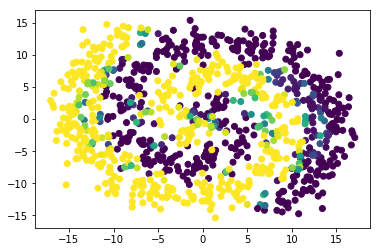

In [66]:
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=out[:, 0].detach().cpu())

## Let's get this bread

In [67]:
import hess.utils as utils

In [68]:
model = optimus.net
par_list = model.parameters()
n_par_w_bias = sum(torch.numel(p) for p in par_list)

In [69]:
n_par_w_bias

1761

In [70]:
e1 = torch.zeros(n_par_w_bias)
e1[0] = 1
e1 = e1.unsqueeze(0)

In [71]:
magic_e1 = utils.unflatten_like(e1, model.parameters())
if use_cuda:
    magic_e1 = [t.cuda() for t in magic_e1]

In [72]:
utils.eval_hess_vec_prod(magic_e1, model.parameters(), 
                         net=optimus.net,
                         criterion=torch.nn.MSELoss(), 
                         inputs=train_x, targets=train_y)

In [73]:
output = utils.gradtensor_to_tensor(optimus.net, include_bn=True)

In [74]:
output.nelement()

1761

In [75]:
base_vec = torch.zeros(n_par_w_bias).cpu().unsqueeze(0)
base_vec[0, 0] = 1.

base_vec = utils.unflatten_like(base_vec, model.parameters())
utils.eval_hess_vec_prod(base_vec, model.parameters(),
                        net=optimus.net.cpu(),
                        criterion=torch.nn.MSELoss(),
                        inputs=train_x.cpu(), targets=train_y.cpu())
output = utils.gradtensor_to_tensor(optimus.net.cpu(), include_bn=True)

n_par = output.nelement()

In [76]:
hessian = torch.zeros(n_par, n_par).cpu()
for pp in range(n_par):
    base_vec = torch.zeros(n_par_w_bias).cpu().unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=optimus.net.cpu(),
                            criterion=torch.nn.MSELoss(),
                            inputs=train_x.cpu(), targets=train_y.cpu())
    if pp == 0:
        output = utils.gradtensor_to_tensor(optimus.net, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    hessian[:, pp] = utils.gradtensor_to_tensor(optimus.net.cpu(), include_bn=True).cpu()

In [77]:
torch.cuda.empty_cache()

In [78]:
e_val, e_vec = np.linalg.eig(hessian.cpu())
idx = e_val.argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

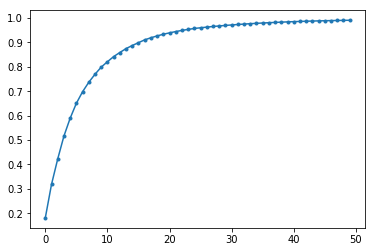

In [79]:
ne = e_val.div(torch.sum(e_val))
plt.plot(np.cumsum(ne[:50].cpu()), marker=".")

## Save model to use on laptop

In [80]:
torch.save(optimus.net.state_dict(), "../hess/saved-models/spirals.pt")
saved_pars = optimus.net.state_dict()

In [81]:
torch.save(hessian, "../hess/saved-models/spirals_hessian.pt")

## Do Some Perturbing

In [82]:
torch.set_default_tensor_type(torch.FloatTensor)
optimus = optimus.cpu();

In [83]:
from hess.plotting import plot_decision_boundary

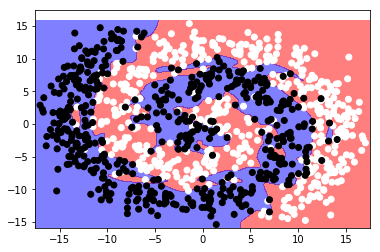

In [84]:
plot_decision_boundary(train_x, train_y, optimus, use_cuda=False,
                      buffer=0.5, h=0.1)

## Average Over Perturbations

In [85]:
buffer = 0.5
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [118]:
n_vec = 3
scale = 0.5
basis = e_vec[:, :n_vec]
n_trial = 100
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus(in_grid).squeeze().cpu()

In [119]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

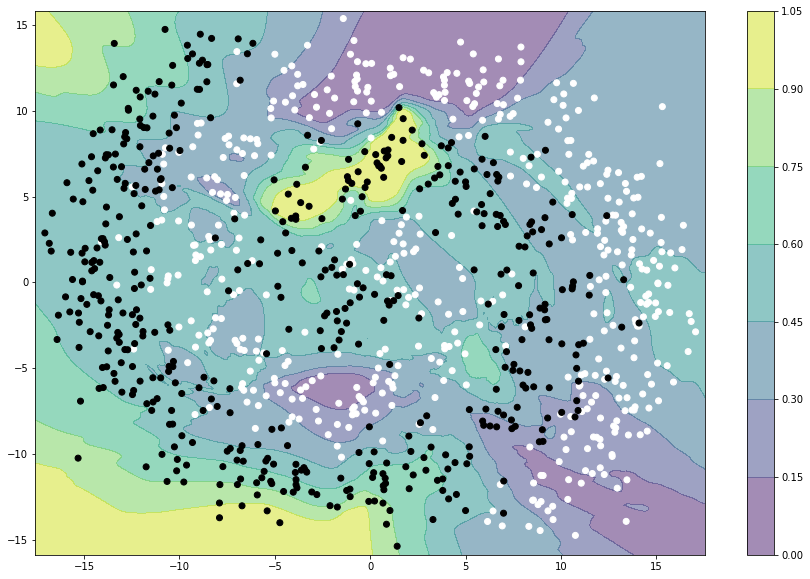

In [120]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)

## Small Curvature

In [121]:
n_vec = 1000
scale = 0.5
basis = e_vec[:, -n_vec:]
n_trial = 100
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus(in_grid).squeeze().cpu()

In [122]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

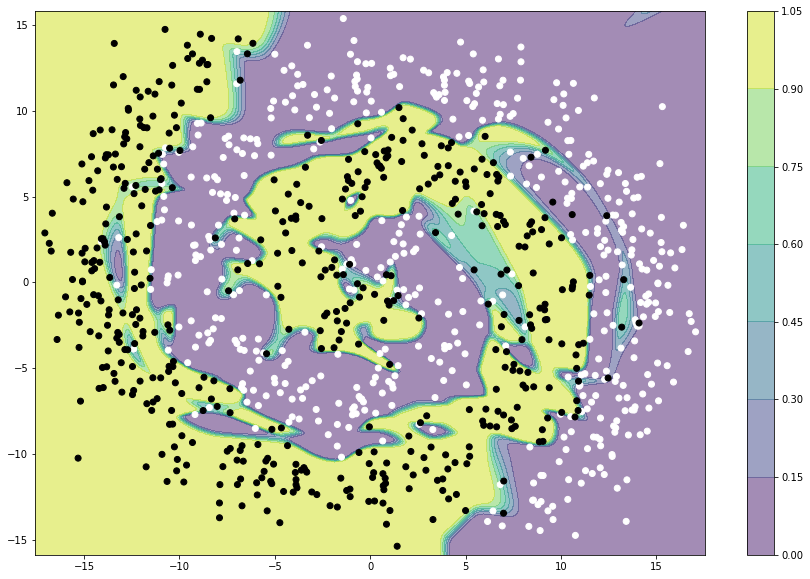

In [123]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)